# Rock-Paper-Scissors
Training a CNN on rock-paper-scissors hand images to build a simple game application

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

## Load dataset

In [3]:
# define paths
train_folder = 'dataset/train'
test_folder = 'dataset/test'
validation_folder = 'dataset/validation'

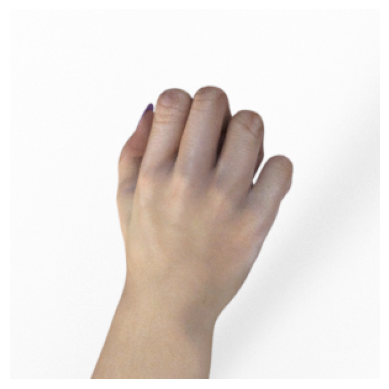

In [4]:
import random

# open test picture
def display_image(path: str) -> None:
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    return image

rock_folder = 'dataset/train/rock'
test_image = random.choice(os.listdir(rock_folder))
image_path = os.path.join(rock_folder, test_image)
img = display_image(image_path)

## Preparing data for the model

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

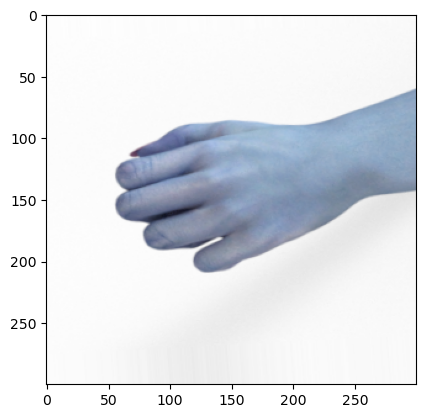

In [7]:
plt.imshow(image_gen.random_transform(img))

In [8]:
image_gen.flow_from_directory(train_folder)

Found 3784 images belonging to 3 classes.


In [9]:
image_gen.flow_from_directory(test_folder)

Found 1259 images belonging to 3 classes.


## Create Model

In [10]:
from keras.models import Sequential
from keras.layers import InputLayer, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [11]:
# Image shape Tensor
image_shape = (150, 100, 3)

# create sequential modle
model = Sequential()

model.add(InputLayer(input_shape=image_shape))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))

# Add 50% dropout to help reduce overfitting
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=3, activation='softmax'))  # 3 classes: 0=rock, 1=paper 2=scissors

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 98, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 10, 128)       

## Training Model

In [12]:
batch_size = 32

train_image_gen = image_gen.flow_from_directory(
    directory=train_folder,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3784 images belonging to 3 classes.


In [13]:
test_image_gen = image_gen.flow_from_directory(
    directory=test_folder,
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1259 images belonging to 3 classes.


In [14]:
# indices
class_indices = train_image_gen.class_indices
print(class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
# results = model.fit(
#     train_image_gen,
#     epochs=100,
#     steps_per_epoch=train_image_gen.samples/train_image_gen.batch_size,
#     validation_data=test_image_gen,
#     validation_steps=test_image_gen.samples/test_image_gen.batch_size,
#     verbose=2)


## Model Evaluation

In [17]:
# plt.plot(results.history['accuracy'])

## Save model

In [18]:
# from datetime import datetime
# timestamp = datetime.now().strftime('%Y%m%d_%H%M')
# model.save(f'models/rps_v03_100epochs_{timestamp}.h5')

## New images prediction

In [19]:
import os
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.models import load_model

success = 0
failure = 0
total = 0

# load model

model = load_model('models/rps_v03_100epochs_20240208_1512.h5')

for subfolder in ['rock', 'paper', 'scissors']:

    current_folder = os.path.join(validation_folder, subfolder)

    for img_name in os.listdir(current_folder):

        img_file = os.path.join(current_folder, img_name)

        img = image.load_img(img_file, target_size=(150, 100))
        img = image.img_to_array(img)

        # add batch dimension
        img = np.expand_dims(img, axis=0)
        img = img/255

        # image prediction probability
        prediction_prob = model.predict(img, verbose=0)
        # print(prediction_prob)

        # Get predicted class index
        predicted_class_index = np.argmax(prediction_prob)

        # Map predicted class index to class label
        predicted_class_label = [k for k, v in class_indices.items() if v == predicted_class_index][0]

        # Print predicted class label
        if subfolder == predicted_class_label:
            success += 1
            result = 'success'
        else:
            failure += 1
            result = 'failure'

        print(f'Image: {img_name} | Class/Predicted: {subfolder} >> {predicted_class_label} | {result}')
        total += 1

print(f"{100*'-'}\nTotal: {total} | Success: {success} | Failure: {failure} | Accuracy: {success/total*100:.2f}%")



Image: rock_d1_validation_0.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_1.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_10.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_100.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_101.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_102.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_103.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_104.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_105.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_106.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_107.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_108.png | Class/Predicted: rock >> rock | success
Image: rock_d1_validation_109.png | Class/Predicted: rock >> rock | success
Image: rock_d1_va